# MultiCamera Paper Results Generation and Plotting

# Cityscapes datadist

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [3]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/new_profiling/cityscapes/meta/profiles_datadist'
INFERENCE_PROFILE_PATH = '../real_inference_profiles.csv'
INFERENCE_MAX_DEFAULT = 0.25

In [4]:
def read_profiles(profile_dir, city_name, use_oracle = False):
    # use_oracle: Use oracle data instead of predictions
    profile_path = os.path.join(profile_dir, "{}.json".format(city_name))
    with open(profile_path) as f:
        data = json.load(f)
    offset = int(sorted(data["taskwise_train_profiles"], key=lambda x: int(x))[0])
    final_data = {"taskwise_train_profiles": {},
                  "taskwise_infer_profiles": {},
                  "taskwise_predicted_profiles": {}}
    for key in data["taskwise_train_profiles"].keys():
        final_data["taskwise_train_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
    for key in data["taskwise_infer_profiles"].keys():
        final_data["taskwise_infer_profiles"][str(int(key)-offset)] = data["taskwise_infer_profiles"][key]
    for key in data["taskwise_predicted_profiles"].keys():
        if use_oracle:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_train_profiles"][key]
        else:
            final_data["taskwise_predicted_profiles"][str(int(key)-offset)] = data["taskwise_predicted_profiles"][key]
    assert "taskwise_train_profiles" in final_data
    assert "taskwise_infer_profiles" in final_data
    return final_data

def create_cameras(city_names, profile_dir = PROFILE_DIR, inference_max_resources = INFERENCE_MAX_DEFAULT, use_oracle = False):
    cameras = []
    print("Creating cameras for cities {}".format(city_names))
    for idx, city in enumerate(city_names):        
        data_pred = read_profiles(profile_dir, city, use_oracle)
        
        TASKS = data_pred["taskwise_train_profiles"].keys()
        # Format = [Acc, res_time, 0]
        train_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_predicted_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # Format = [Acc, res_time, 0]
        oracle_profiles = {TASK_ID: [[x[2], x[3], 0] for x in data_pred["taskwise_train_profiles"][TASK_ID]] for TASK_ID in TASKS}
        
        # TODO: Picking min profile, which else can we pick?
        infer_start_accs = {TASK_ID: min([acc for hp_id, acc in data_pred["taskwise_infer_profiles"][TASK_ID].items()]) for TASK_ID in TASKS}

        cameras.append(Camera("{}_{}".format(city, idx),
                              train_profiles,
                              oracle_profiles,
                              infer_start_accs,
                              inference_profile_path=INFERENCE_PROFILE_PATH,
                              inference_max_resources=inference_max_resources
                             ))
    return cameras

# Cost vs accuracy - Multi Cam

In [27]:
def get_citywise_data(results, city):
    tasks = list(results.keys())
    tasks.remove('meta')
    final_data = None
    for task in tasks:
        for job in results[task].keys():
            if isinstance(job, InferenceJob):
                if city in job.name:
                    d = results[task][job]
                    time, acc = list(zip(*d))
                    print(task)
                    data = pd.DataFrame(acc, columns=['task_{}'.format(task)], index=time)
                    data.index.name = 'time'
                    if final_data is None:
                        final_data = data
                    else:
                        final_data = final_data.join(data)
    return final_data

In [19]:
l=os.listdir(PROFILE_DIR)
cities=[x.split('.')[0] for x in l]
print(cities)

['aachen', 'tubingen', 'zurich', 'bremen', 'bochum', 'cologne', 'dusseldorf', 'darmstadt', 'monchengladbach', 'stuttgart']


In [21]:
%%capture
data = []
all_data = pd.DataFrame()
#cities = ["phx-21-40", "phx-41-60"]
INFER_MAX_RES = 0.25

periods_to_test = [100] #[10, 50, 100, 200, 400]
provisioned_res_to_test = [1,2,4,6,8,10]#np.arange(0,1,0.2)#,2,4,8,16]#,32,64]#[1,2,4,8,16]#list(np.arange(0,1,0.05))#
task_ids = [str(x) for x in range(1,6)]
use_oracle_modes = [False]

allocation = defaultdict(dict)
camera_names_list = [["zurich"],
                     ["zurich"]*2,
                     ["zurich"]*4,
                     ["zurich"]*6,
                     ["zurich"]*8,
                     ["zurich"]*10,
                     ["zurich"]*12,
                     ["zurich"]*14]

schedulers_to_test = [(fair_dumb_scheduler, 'fair_dumb'),
                     # (fair_naive_scheduler, 'fair_naive'),
                     # (fair_sco_scheduler, 'fair_sco'),
                     (lambda x,y,z: thief_sco_scheduler(x,y,z,iterations=2,steal_increment=INFER_MAX_RES/3), 'thief'),
                     (inference_only_scheduler, 'inference_only')
                     ]

column_names = ['period', 'resources', 'use_oracle', *[sched_name for _, sched_name in schedulers_to_test]]
for retraining_period in periods_to_test:
    for provisioned_res in provisioned_res_to_test:
        for use_oracle in use_oracle_modes:
            for camera_names in camera_names_list:
                this_config_result = [retraining_period, provisioned_res, use_oracle]
                for scheduler, sched_name in schedulers_to_test:
                    print("Sched: {}, Resources: {}. Period: {}. Use_Oracle: {}.".format(
                        sched_name, provisioned_res, retraining_period, use_oracle))
                    cameras = create_cameras(camera_names, inference_max_resources = INFER_MAX_RES, use_oracle=use_oracle)
                    mps = MultiPeriodSimulator(cameras, provisioned_res, scheduler, retraining_period, task_ids = task_ids)
                    results, period_allocation_log = mps.step_till_completion()

                    #Get citywise data
                    for city_alias in [c.name for c in cameras]:
                        d=get_citywise_data(results, city_alias)
                        d['city']=city_alias
                        d['res']=provisioned_res
                        d['period']=retraining_period
                        d['use_oracle']=use_oracle
                        d['sched'] = sched_name
                        d['num_cams'] = len(camera_names)
                        all_data = pd.concat([all_data, d])

                    this_config_result.append(results['meta']['overall_inf_mean_auc'])
                    allocation["{}_{}_{}_{}_{}".format(retraining_period, provisioned_res, sched_name, use_oracle, len(camera_names))] = period_allocation_log
                data.append(this_config_result)
                df = pd.DataFrame(data, columns=column_names)
                df.to_csv('data_eval_multicam_varyingcam_extensive_cityscapes_datadist.csv')
                all_data.to_csv('data_eval_multicam_varyingcam_extensive_all_data_cityscapes_datadist.csv')

                with open('data_eval_multicam_varyingcam_extensive_allocationdata_cityscapes_datadist.json', 'w') as outfile:
                    json.dump(allocation, outfile)

ValueError: columns overlap but no suffix specified: Index(['task_1'], dtype='object')

In [26]:
results

{'1': defaultdict(list,
             {<utilitysimv4.TrainingJob at 0x7fc3f97b9b00>: [[0,
                0.5133213936540206],
               [1, 0.51402970952865],
               [2, 0.5147380254032795],
               [3, 0.5154463412779089],
               [4, 0.5161546571525383],
               [5, 0.5168629730271677],
               [6, 0.517571288901797],
               [7, 0.5182796047764264],
               [8, 0.5189879206510558],
               [9, 0.5196962365256852],
               [10, 0.5204045524003147],
               [11, 0.5211128682749441],
               [12, 0.5218211841495735],
               [13, 0.5225295000242028],
               [14, 0.5232378158988322],
               [15, 0.5239461317734616],
               [16, 0.524654447648091],
               [17, 0.5253627635227204],
               [18, 0.5260710793973498],
               [19, 0.5267793952719793],
               [20, 0.5274877111466086],
               [21, 0.528196027021238],
               [22, 0.52890

In [33]:
def get_citywise_data(results, city):
    tasks = list(results.keys())
    tasks.remove('meta')
    final_data = None
    for task in tasks:
        print("t: {}".format(task))
        for job in results[task].keys():
            if isinstance(job, InferenceJob):
                if city in job.name:
                    d = results[task][job]
                    time, acc = list(zip(*d))
                    print(task)
                    data = pd.DataFrame(acc, columns=['task_{}'.format(task)], index=time)
                    data.index.name = 'time'
                    if final_data is None:
                        final_data = data
                    else:
                        final_data = final_data.join(data)
    return final_data

In [34]:
results['1']

defaultdict(list,
            {<utilitysimv4.TrainingJob at 0x7fc3f97b9b00>: [[0,
               0.5133213936540206],
              [1, 0.51402970952865],
              [2, 0.5147380254032795],
              [3, 0.5154463412779089],
              [4, 0.5161546571525383],
              [5, 0.5168629730271677],
              [6, 0.517571288901797],
              [7, 0.5182796047764264],
              [8, 0.5189879206510558],
              [9, 0.5196962365256852],
              [10, 0.5204045524003147],
              [11, 0.5211128682749441],
              [12, 0.5218211841495735],
              [13, 0.5225295000242028],
              [14, 0.5232378158988322],
              [15, 0.5239461317734616],
              [16, 0.524654447648091],
              [17, 0.5253627635227204],
              [18, 0.5260710793973498],
              [19, 0.5267793952719793],
              [20, 0.5274877111466086],
              [21, 0.528196027021238],
              [22, 0.5289043428958674],
              [2

In [35]:
get_citywise_data(results, city_alias)

t: 1
1
1


ValueError: columns overlap but no suffix specified: Index(['task_1'], dtype='object')

In [149]:
x=citywise_data[(citywise_data['sched']=='thief') & (citywise_data['res']==0.8) & (citywise_data['period']==100) & (citywise_data['use_oracle']==True)]# & (citywise_data['city']=="phx-21-40")]

In [150]:
tasks = [t for t in x.mean().keys() if "task" in t]
x.mean()[tasks].mean()

0.8246860780410408

In [160]:
df

,period,resources,use_oracle,fair_dumb,fair_sco,thief,inference_only
0,100,1,True,0.302295,0.368399,0.478587,0.486555


# Plotting

In [47]:
PERIOD=100
USE_ORACLE_INFO = False
d = df
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['fair_dumb', 'thief', 'inference_only']

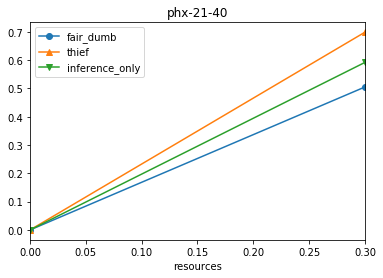

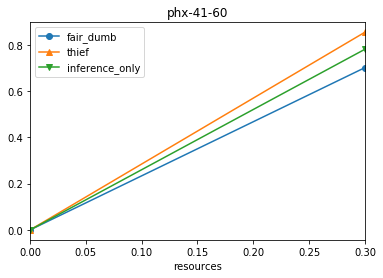

In [56]:
# Cost vs Resource

cities = d.city.unique()
for city in cities:
    temp_df = d[d['city']==city]
    ax = temp_df.plot(x='resources', y=scheds, kind='line',
                        title=city,
                        legend=True, style=['o-', '^-', 'v-'])

In [57]:
d

,city,period,resources,use_oracle,fair_dumb,thief,inference_only
1,phx-21-40,100,0.0,False,0.000000,0.000000,0.000000
3,phx-21-40,100,0.3,False,0.504749,0.698170,0.591501
5,phx-41-60,100,0.0,False,0.000000,0.000000,0.000000
7,phx-41-60,100,0.3,False,0.700924,0.853869,0.780291


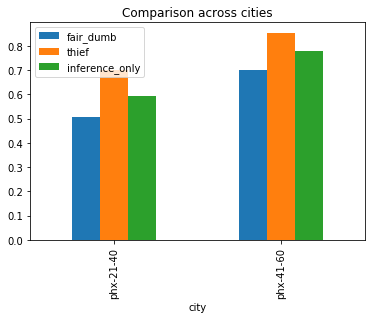

In [66]:
# Comparison across cameras
COMPARE_RES = 0.3
ax = d[d['resources']==COMPARE_RES].plot(x='city', y=scheds, kind='bar',
                  title="Comparison across cities")